# Modeling the disparity between experienced and residential nativity segregation

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [2]:
# Load libs
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingRegressor
import shap

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-colorblind')
font = {'size': 14}
mpl.rc('font', **font)

In [4]:
df_exp = pd.read_parquet('results/data4model_individual.parquet')
df_exp = df_exp.loc[(df_exp['weekday'] == 1) & (df_exp['holiday'] == 0), :]

## 1. Select variables

In [5]:
cols = ['uid', 'region', 'wt_p', 'Lowest income group',
        'car_ownership', 'cum_jobs', 'cum_stops',
        'ice_birth_resi', 'ice_birth']
df_exp = df_exp[cols]

### 1.1 Add labels of home regions (A, B, and C)
A DeSO in category A is mostly outside major population concentrations or urban areas. DeSO in category B is mostly located in a population concentration or agglomeration, but not in the municipality's central location. Category C includes DeSO, which is mostly located in the municipality's central location. In total, 18 percent of DeSO are found in category A, 10 percent in category B and 72 percent in category C.

Source: [SCB.se](https://www.scb.se/hitta-statistik/regional-statistik-och-kartor/regionala-indelningar/deso---demografiska-statistikomraden/)

In [6]:
df_exp['deso_2'] = df_exp['region'].apply(lambda x: x[0:2])
df_exp['region_cat'] = df_exp['region'].apply(lambda x: x[4])

## 2. Grouping segregation patterns

In [7]:
def seg_direction(row):
    if row['ice_birth_resi'] < 0:
        if row['ice_birth'] < 0:
            return 'FF'
        else:
            return 'FD'
    else:
        if row['ice_birth'] < 0:
            return 'DF'
    return 'DD'

def delta_ice(ice_r, ice_e):
    if ice_r < 0:
        return -(ice_e - ice_r)
    return ice_e - ice_r

def seg_abs_direction(x):
    if x >= 0:
        return 'inc'
    return 'dec'

In [33]:
df_exp['seg_gap'] = df_exp.apply(lambda row: delta_ice(row['ice_birth_resi'], row['ice_birth']), axis=1)
df_exp['seg_cross'] = df_exp.apply(lambda row: seg_direction(row), axis=1)
df_exp['seg_change'] = df_exp.apply(lambda row: seg_abs_direction(row['seg_gap']), axis=1)
df_exp['seg_r'] = df_exp.apply(lambda row: row['seg_cross'][0], axis=1)
df_exp['region_cat2'] = df_exp['region_cat'].apply(lambda x: 'Rural/Suburban' if x in ('A', 'B') else 'Urban')
df_exp.iloc[0]

uid                    00008608-f79e-414d-bf1c-25632d6bc059
region                                            1284C1040
wt_p                                              84.428571
Lowest income group                                0.088063
car_ownership                                      0.541455
cum_jobs                                        4813.309325
cum_stops                                               3.0
ice_birth_resi                                     0.324146
ice_birth                                          0.041918
deso_2                                                   12
region_cat                                                C
seg_gap                                           -0.282228
seg_cross                                                DD
seg_change                                              dec
seg_r                                                     D
region_cat2                                           Urban
Name: 570844, dtype: object

In [34]:
df_exp.to_parquet("results/transport_association/seg_disparity_patterns.parquet")

### 2.1 Statistics of these groups

In [10]:
df_exp.groupby(['seg_r', 'seg_change'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r  seg_change
D      dec           64.102028
       inc            1.635886
F      dec           10.268291
       inc           23.993795
Name: wt_p, dtype: float64

In [35]:
df_exp.groupby(['region_cat2'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

region_cat2
Rural/Suburban    22.988504
Urban             77.011496
Name: wt_p, dtype: float64

In [29]:
df_exp.groupby(['seg_r'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r
D    65.737913
F    34.262087
Name: wt_p, dtype: float64

## 3. Quantify segregation disparity

### 3.1 Calculate boxplot stats

In [56]:
def seg_grp_stats_com(data, var=None):
    stat_dict = {'share': data.wt_p.sum() / df_exp.wt_p.sum() * 100}
    wdf = DescrStatsW(data[var], weights=data['wt_p'], ddof=1)
    sts = wdf.quantile([0.25,0.50,0.75])
    q25 = sts.values[0]
    q50 = sts.values[1]
    q75 = sts.values[2]
    stat_dict['mean'] = wdf.mean
    stat_dict['q25'] = q25
    stat_dict['q50'] = q50
    stat_dict['q75'] = q75
    stat_dict['var'] = var
    return pd.Series(stat_dict)

def stats_calculation(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_seg = []
    for var in ['Lowest income group', 'car_ownership', 'cum_jobs', 'cum_stops']:
        list_df_seg.append(df_exp.groupby(['seg_r', 'seg_change', 'region_cat2']).
                           apply(lambda x: seg_grp_stats_com(x, var)).
                           reset_index())
    df_seg = pd.concat(list_df_seg)
    df_seg.loc[:, 'seg_change'] = df_seg['seg_change'].map({'inc': 'Increase',
                                                            'dec': 'Decrease'})
    if focus_thr:
        df_seg.loc[:, 'focus'] = 'yes'
    else:
        df_seg.loc[:, 'focus'] = 'no'
    return df_seg

In [57]:
df_seg = pd.concat([stats_calculation(df=df_exp, focus_thr=False),
                    stats_calculation(df=df_exp, focus_thr=True)])

In [58]:
df_seg.to_parquet('results/transport_association/seg_disarity_patterns_stats.parquet')
df_seg

,seg_r,seg_change,region_cat2,share,mean,q25,q50,q75,var,focus
0,D,Decrease,Rural/Suburban,21.311984,0.213918,0.000000,0.187500,0.333333,Lowest income group,no
1,D,Decrease,Urban,42.790044,0.186343,0.085714,0.162500,0.260188,Lowest income group,no
2,D,Increase,Rural/Suburban,0.310197,0.270702,0.121212,0.230769,0.380952,Lowest income group,no
3,D,Increase,Urban,1.325689,0.224804,0.107143,0.216039,0.308311,Lowest income group,no
4,F,Decrease,Rural/Suburban,0.311321,0.321306,0.170213,0.338983,0.449324,Lowest income group,no
...,...,...,...,...,...,...,...,...,...,...
3,D,Increase,Urban,0.517655,142.067306,13.000000,22.000000,116.000000,cum_stops,yes
4,F,Decrease,Rural/Suburban,0.142564,18.145998,5.000000,13.000000,21.000000,cum_stops,yes
5,F,Decrease,Urban,5.619932,120.039847,18.000000,29.000000,94.000000,cum_stops,yes
6,F,Increase,Rural/Suburban,0.469483,14.037274,6.000000,12.000000,21.000000,cum_stops,yes


### 3.2 Vislualization
This part is done in `30-1-seg-disp-patterns-cat.R`.

## 4. Weighted Mann–Whitney U test

In [42]:
import os
os.environ['R_HOME'] = "C:\Program Files\R\R-4.0.2"
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as rpyn
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
with conversion.localconverter(default_converter):
    r_weights = importr('survey')

In [49]:
def wmu_test(data=None, region=None, grps=None, var=None, weight=None):
    data1 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'dec'), [var, weight]]
    data2 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'inc'), [var, weight]]
    weights = np.concatenate([data1[weight].values, data2[weight].values])
    group1 = data1[var].values
    group2 = data2[var].values
    with conversion.localconverter(default_converter):
        ro.r.assign('group1', rpyn.numpy2rpy(group1))
        ro.r.assign('group2', rpyn.numpy2rpy(group2))
        ro.r.assign('weights', rpyn.numpy2rpy(weights))
        ro.r('''data <- data.frame(group = c(group1, group2),
                        group_indicator = rep(c(1, 2), c(length(group1), length(group2))))''')
        ro.r('''design <- svydesign(ids = ~0, data = data, weights = ~weights)''')
        ro.r('''result <- svyranktest(formula = group ~ group_indicator, design=design, test = "wilcoxon")''')
        ro.r('''est <- unname(result$estimate)''')
        ro.r('''pvalue <- unname(result$p.value)''')
        est = ro.globalenv['est'][0]
        pvalue = ro.globalenv['pvalue'][0]
    return est, pvalue

In [54]:
weight = 'wt_p'
res_list = []
for var in ['Lowest income group', 'car_ownership', 'cum_jobs', 'cum_stops']:
    for rg in ['Rural/Suburban', 'Urban']:
        for grp in ['D', 'F']:
            est, pvalue = wmu_test(data=df_exp, region=rg, grps=grp, var=var, weight=weight)
            grp_type = grp[0]
            if pvalue > 0.001:
                sig = '-'
            else:
                sig = '*'
            res_list.append((var, rg, grp_type, pvalue, sig, est))
df_res = pd.DataFrame(res_list, columns=['var', 'region_cat', 'seg_r', 'p', 'sig', 'difference in mean rank score'])
df_res

,var,region_cat,seg_r,p,sig,difference in mean rank score
0,Lowest income group,Rural/Suburban,D,5.186499e-11,*,0.080746
1,Lowest income group,Rural/Suburban,F,2.091690e-01,-,0.015946
2,Lowest income group,Urban,D,6.395267e-28,*,0.078795
3,Lowest income group,Urban,F,7.696441e-242,*,-0.081125
4,car_ownership,Rural/Suburban,D,5.884797e-49,*,-0.185375
5,car_ownership,Rural/Suburban,F,1.280281e-02,-,0.031118
6,car_ownership,Urban,D,8.417796e-07,*,0.029937
7,car_ownership,Urban,F,0.000000e+00,*,0.115664
8,cum_jobs,Rural/Suburban,D,2.351337e-01,-,-0.013540
9,cum_jobs,Rural/Suburban,F,5.999118e-02,-,0.025914


In [40]:
df_res.to_clipboard(index=False)

In [55]:
df_res.to_parquet('results/transport_association/stats_test.parquet')

## 5. EBM model predicting segregation gap

In [37]:
def ebm_group(data, title='Test', weight_field=None, shap_size=500):
#    data = pd.get_dummies(data, columns=['region_cat'], prefix='region_cat_', prefix_sep='')
    data = data.rename(columns={'car_ownership': 'Car ownership (/capita)',
                                'cum_jobs': 'Car accessibility to jobs',
                                'cum_stops': 'Access to transit stops'})
    predictors = ['Lowest income group', 'Car ownership (/capita)',
                  'Car accessibility to jobs', 'Access to transit stops']

    target_column = 'seg_gap'
    X = data[predictors]
    y = data[target_column]
    sample_weight = data[weight_field]

    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, sample_weight, test_size=0.00001, random_state=40)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    seed = 1
    ebm = ExplainableBoostingRegressor(interactions=3, random_state=seed, feature_names=predictors, outer_bags=2)
    ebm.fit(X_train, y_train, sample_weight=weight_train)
    # explain the GAM model with SHAP
    background = shap.maskers.Independent(X_train, max_samples=1000)
    explainer_ebm = shap.Explainer(ebm.predict, background)
    shap_values_ebm = explainer_ebm(X_train[:shap_size])
    shap_values_ebm.feature_names = predictors
    # Customize the order of features
    order = predictors
    col2num = {col: i for i, col in enumerate(X.columns)}
    order = list(map(col2num.get, order))
    # Get the current figure and axes objects.
    fig = plt.figure(figsize=(5, 3))
    shap.plots.beeswarm(shap_values_ebm, order=order, show=False, alpha=0.5, log_scale=False)
    # Make the modifications that you want.  I wanted
    # to resize the x-axis, but you can do anything that you'd like.
    plt.title(title)
    # plt.xlim(-0.3, 0.3)
    plt.xlabel('Impact on nativity segregation change')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'figures/ebm/ice_gap_shap_{title.replace("/", "_")}.png', dpi=300)

Exact explainer: 10001it [00:30, 213.54it/s]                          


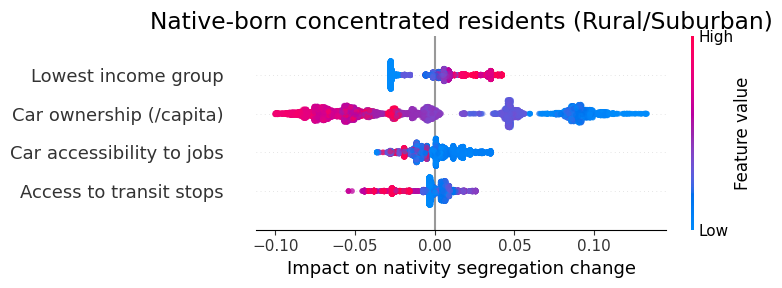

Exact explainer: 10001it [00:30, 211.70it/s]                          


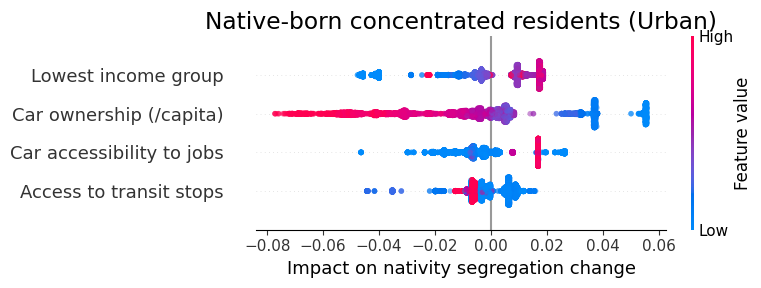

Exact explainer: 3927it [00:10, 19.52it/s]                           


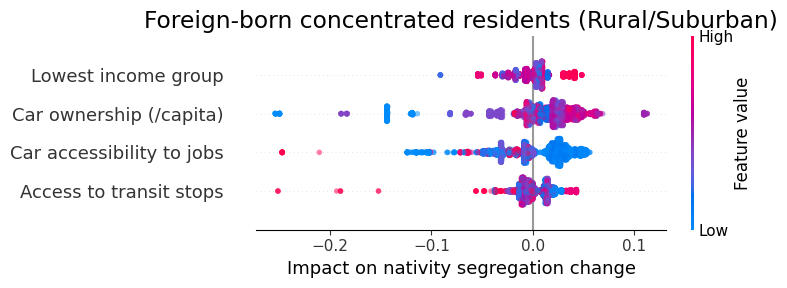

Exact explainer: 10001it [00:29, 213.79it/s]                          


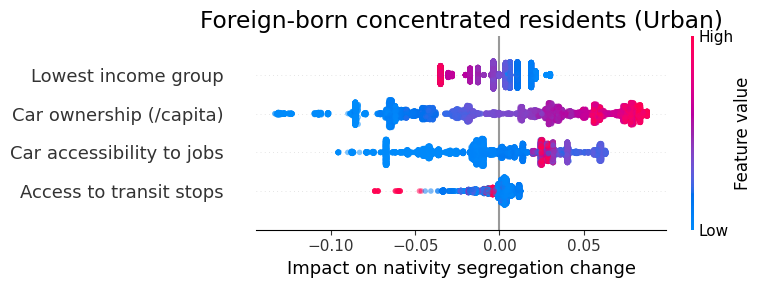

In [38]:
seg_dict = {'D': 'Native-born concentrated residents',
            'F': 'Foreign-born concentrated residents'}
for grp, df in df_exp.groupby(['seg_r', 'region_cat2']):
    title = seg_dict[grp[0]] + f' ({grp[1]})'
    ebm_group(df, title=title, weight_field='wt_p', shap_size=10000)